In [ ]:
!pip install investpy

In [ ]:
import pandas as pd
import numpy as np
import investpy
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from datetime import datetime

sns.set_style('darkgrid')

In [ ]:
df = investpy.get_currency_cross_historical_data(currency_cross='EUR/USD', from_date='01/01/2010', to_date='02/07/2021')

In [ ]:
df.head()

,Open,High,Low,Close,Currency
Date,,,,,
2010-01-01,1.4328,1.4330,1.4322,1.4326,USD
2010-01-04,1.4325,1.4457,1.4257,1.4413,USD
2010-01-05,1.4409,1.4484,1.4346,1.4369,USD
2010-01-06,1.4364,1.4436,1.4282,1.4413,USD
2010-01-07,1.4407,1.4447,1.4295,1.4318,USD


In [ ]:
df['date'] = df.index
df = df.reset_index(drop=True)

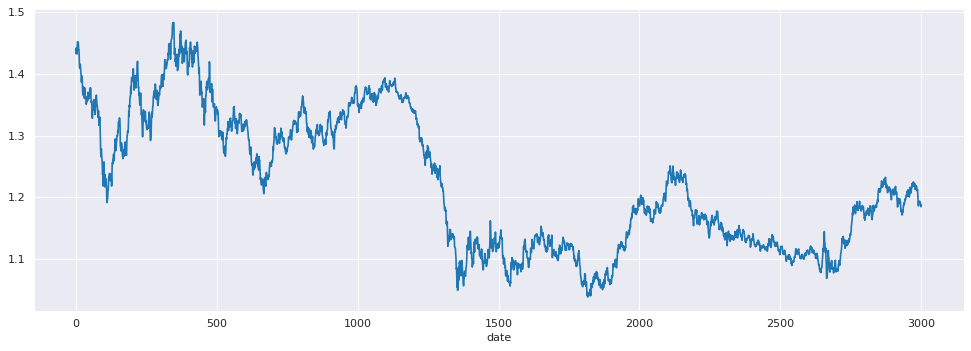

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(df['Close'], label='close')
plt.xlabel('date')
plt.show()

In [ ]:
SMA30 = pd.DataFrame()
SMA30['Close'] = df['Close'].rolling(window=30).mean()

In [ ]:
SMA100 = pd.DataFrame()
SMA100['Close'] = df['Close'].rolling(window=100).mean()

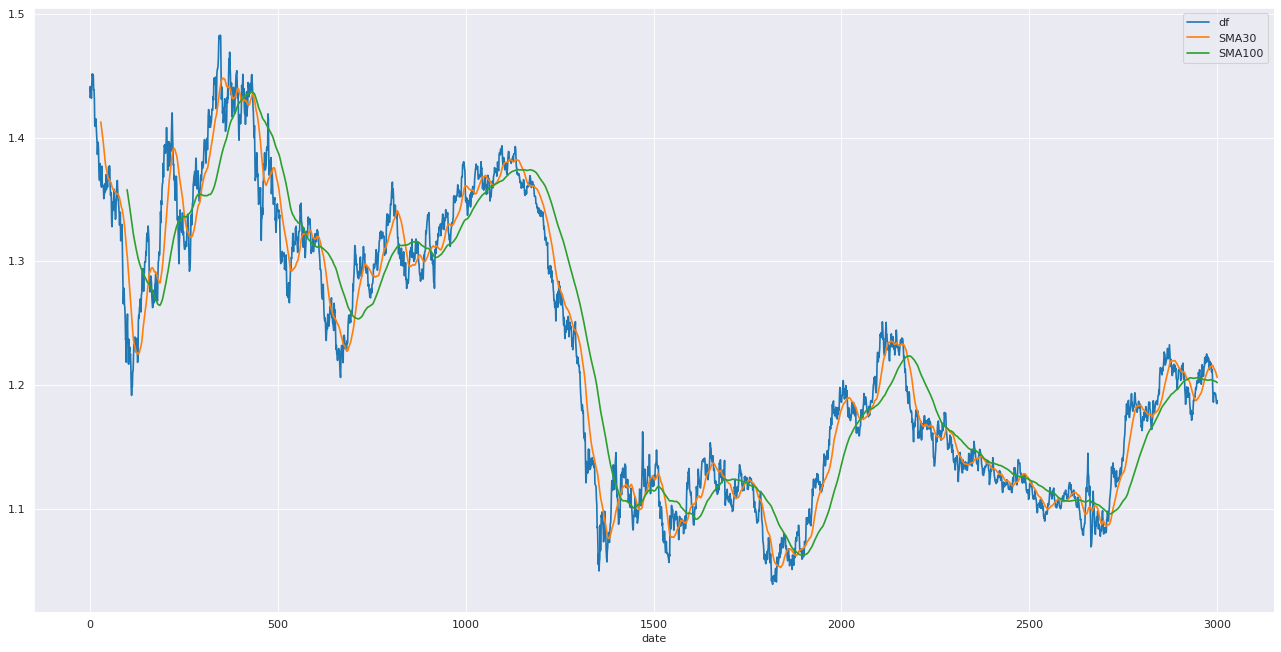

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(df['Close'], label='df')
plt.plot(SMA30['Close'], label='SMA30')
plt.plot(SMA100['Close'], label='SMA100')
plt.xlabel('date')
plt.legend(loc='best')
plt.show()

In [ ]:
new_df = pd.DataFrame()
new_df ['Close'] = df['Close']
new_df['date'] = df['date']
new_df['SMA30'] = SMA30['Close']
new_df['SMA100'] = SMA100['Close']

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Close   3001 non-null   float64       
 1   date    3001 non-null   datetime64[ns]
 2   SMA30   2972 non-null   float64       
 3   SMA100  2902 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 93.9 KB


In [ ]:
def dual_sma(df):
  buy = []
  sell = []
  flag = 0

  for i in range(len(df)):
    if df['SMA30'][i] > df ['SMA100'][i]:
      if flag != 1:

        buy.append(df['Close'][i])
        sell.append(np.nan)
        flag = 1

      else:
        sell.append(np.nan)
        buy.append(np.nan)

    elif df['SMA30'][i] < df ['SMA100'][i]: 

      if flag != -1:
        sell.append(df['Close'][i])
        buy.append(np.nan)
        flag = -1
      else:
        sell.append(np.nan)
        buy.append(np.nan) 
    else:
      buy.append(np.nan)
      sell.append(np.nan)
  return buy, sell

In [ ]:
dual_sma_buy, dual_sma_sell = dual_sma(new_df)


In [ ]:
new_df['Buy'] = pd.Series(dual_sma_buy)
new_df['Sell'] = pd.Series(dual_sma_sell)

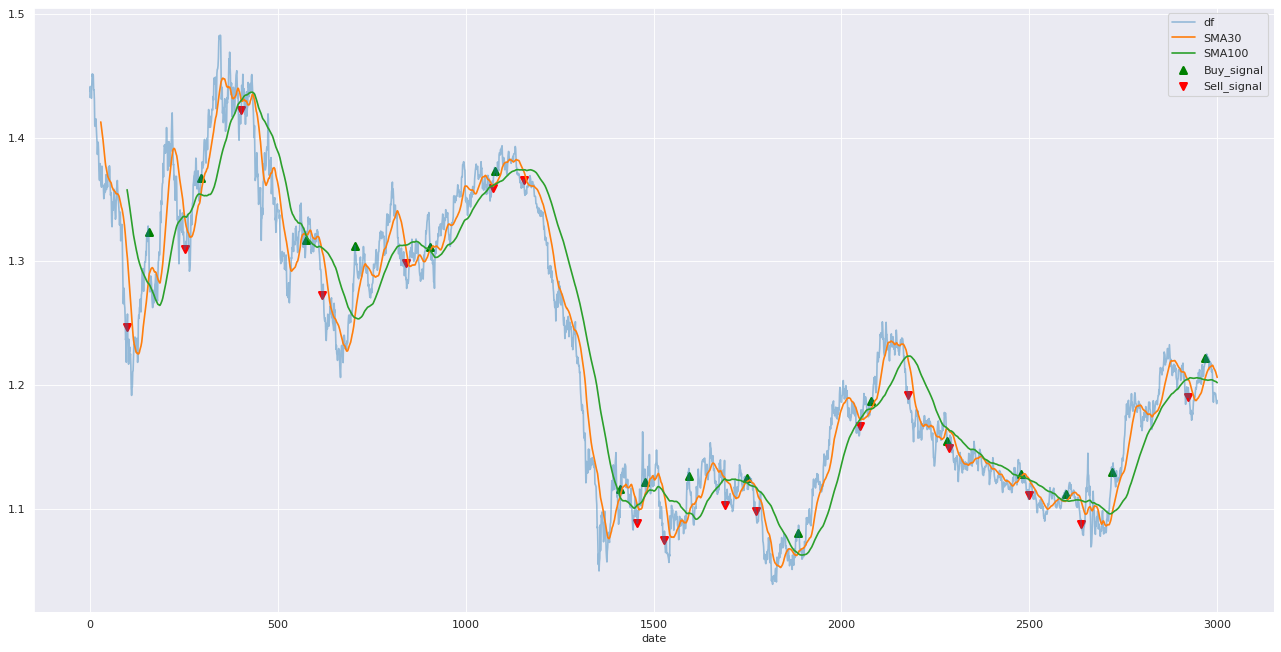

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(new_df['Close'], label='df', alpha=.42)
plt.plot(new_df['SMA30'], label='SMA30')
plt.plot(new_df['SMA100'], label='SMA100')
plt.scatter(new_df.index, new_df['Buy'], color='green', label='Buy_signal',
            marker='^', lw=2.1)
plt.scatter(new_df.index, new_df['Sell'], color='red', label='Sell_signal',
            marker='v', lw=2.1)
plt.xlabel('date')
plt.xticks
plt.legend(loc='best')
plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=new_df['date'], y=new_df['Close'],
                    mode='lines',
                    name='close_price'))
fig.add_trace(go.Scatter(x=new_df['date'], y=new_df['SMA30'],
                    mode='lines',
                    name='SMA30'))
fig.add_trace(go.Scatter(x=new_df['date'], y=new_df['SMA100'],
                    mode='lines',
                    name='SMA100'))
fig.add_trace(go.Scatter(x=new_df['date'], y=new_df['Sell'],
                    mode='markers',
                    name='Sell'))
fig.add_trace(go.Scatter(x=new_df['date'], y=new_df['Buy'],
                    mode='markers',
                    name='Buy'))
fig.update_traces(marker=dict(size=8.4,
                              line=dict(width=0.05,
                                        color='LightSkyBlue')))

fig.show()

## Модель

In [ ]:
new_df.tail()

,Close,date,SMA30,SMA100,Buy,Sell
2996,1.1924,2021-06-28,1.210490,1.202824,NaN,NaN
2997,1.1895,2021-06-29,1.209407,1.202602,NaN,NaN
2998,1.1855,2021-06-30,1.208350,1.202341,NaN,NaN
2999,1.1848,2021-07-01,1.207090,1.202061,NaN,NaN
3000,1.1874,2021-07-02,1.206073,1.201817,NaN,NaN


In [ ]:
def create_features(data):
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day


In [ ]:
create_features(new_df)

In [ ]:
new_df

,Close,date,SMA30,SMA100,Buy,Sell,year,month,day
0,1.4326,2010-01-01,NaN,NaN,NaN,NaN,2010,1,1
1,1.4413,2010-01-04,NaN,NaN,NaN,NaN,2010,1,4
2,1.4369,2010-01-05,NaN,NaN,NaN,NaN,2010,1,5
3,1.4413,2010-01-06,NaN,NaN,NaN,NaN,2010,1,6
4,1.4318,2010-01-07,NaN,NaN,NaN,NaN,2010,1,7
...,...,...,...,...,...,...,...,...,...
2996,1.1924,2021-06-28,1.210490,1.202824,NaN,NaN,2021,6,28
2997,1.1895,2021-06-29,1.209407,1.202602,NaN,NaN,2021,6,29
2998,1.1855,2021-06-30,1.208350,1.202341,NaN,NaN,2021,6,30
2999,1.1848,2021-07-01,1.207090,1.202061,NaN,NaN,2021,7,1


In [ ]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]


In [ ]:
X_train, y_train = split_data(new_df, 'Close')
X_train = X_train.drop(['date', 'SMA30',	'SMA100',	'Buy','Sell'], axis=1)

In [ ]:
lgb_reg = lgb.LGBMRegressor()

params = {
    'learning_rate' : [0.1, 0.25, 0.5],
    'n_estimators' : range(200, 1201, 200),
    'objective' : ['root_mean_squared_error']
}

In [ ]:
lgb_reg_cv = RandomizedSearchCV(lgb_reg, params, scoring='neg_mean_squared_error', 
                             cv=5, random_state=42)

In [ ]:
lgb_reg_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsa

In [ ]:
lgb_reg_cv.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.25, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1200, n_jobs=-1, num_leaves=31,
              objective='root_mean_squared_error', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31,
              objective='root_mean_squared_error', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31,
              objective='root_mean_squared_error', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
rmse = mean_squared_error(y_train, model.predict(X_train))**0.5

In [ ]:
rmse

0.007693802223912635